<a href="https://colab.research.google.com/github/sbg0700/Larvathon1st/blob/main/Larvathon_PRJ_codebase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ 사용 가능한 HbA1c 관련 컬럼: ['HbA1c_any']

LinearRegression 회귀 성능:
 - RMSE: 0.462
 - MAE : 0.311
 - R²  : 0.637

RandomForestRegressor 회귀 성능:
 - RMSE: 0.473
 - MAE : 0.308
 - R²  : 0.619


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


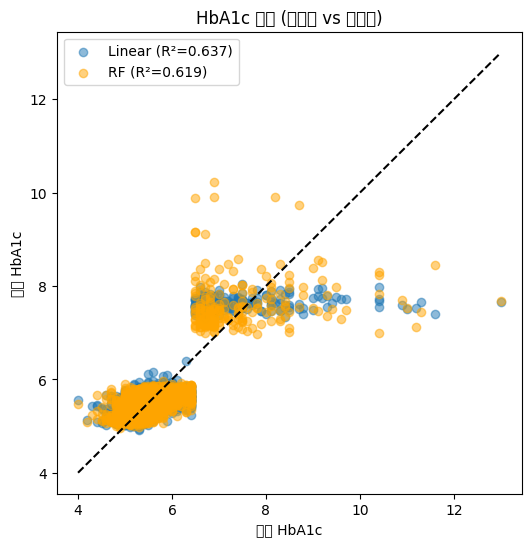

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45817 (\N{HANGUL SYLLABLE DANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45544 (\N{HANGUL SYLLABLE NYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54744 (\N{HANGUL SYLLABLE HEOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54924 (\N{HANGUL SYLLABLE HOE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr

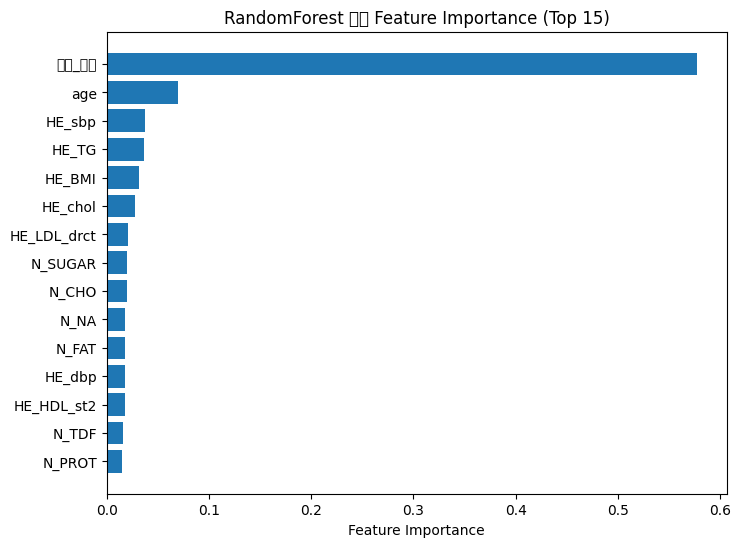


[해석 가이드]
- R²: 0.5 이상이면 실질적 예측 가능성 있음 (0~1)
- RMSE/MAE: HbA1c 단위(%) 기준으로 오차 해석 (예: RMSE 0.35 → 평균 0.35%p 오차)
- 중요 변수: age, BMI, TG, LDL, 혈압, 당류 섭취량 등 → 임상 타당성 확인


In [1]:
# ============================================
# HbA1c 회귀 예측 모델 (확장판)
#  - 변경 내역을 이해하기 쉽도록
#    [분류 코드]는 주석으로 보존하고
#    [회귀 코드]는 실행되도록 구성
# ============================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# --------- [평가지표] 분류 → 회귀로 교체 ---------
# (분류) from sklearn.metrics import (classification_report, roc_auc_score, roc_curve,
#                                     precision_recall_curve, average_precision_score)
#  - 이유: 분류(0/1) 성능을 보는 지표 → ROC/PR 커브, F1 등
# (회귀)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#  - 이유: 연속값(HbA1c)의 오차 크기/설명력을 직접 평가해야 하므로
#          RMSE/MAE/R²로 교체

# --------- [모델] 분류 → 회귀로 교체 ---------
# (분류) from sklearn.linear_model import LogisticRegression
# (분류) from sklearn.ensemble import RandomForestClassifier
#  - 이유: 로지스틱/Classifier는 0/1만 다룸
# (회귀)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
#  - 이유: HbA1c(연속값) 예측을 위해 LinearRegression, RandomForestRegressor 사용

# -------------------------------------------------------------
# 1) 데이터 로드 (동일)
# -------------------------------------------------------------
DATA_PATH = '/content/modeling_dataset_hba1c_Excel.csv'
assert os.path.exists(DATA_PATH), f"CSV가 보이지 않습니다: {DATA_PATH}"

df = pd.read_csv(DATA_PATH, encoding='cp949')

# -------------------------------------------------------------
# 2) 타깃 설정
# -------------------------------------------------------------
# (분류)
# y = df['당뇨_위험'].astype(int)
#  - 이유: HbA1c 임계값으로 파생한 0/1 라벨을 예측
#
# (회귀) ↓↓↓ [변경]
target_candidates = [c for c in df.columns if 'hba1c' in c.lower()]   # 추가: HbA1c 컬럼 자동 탐색
print("✅ 사용 가능한 HbA1c 관련 컬럼:", target_candidates)
target_col = target_candidates[0]                                     # 예: 'HE_HbA1c'
y = df[target_col].astype(float)                                      # HbA1c 연속값 예측

# -------------------------------------------------------------
# 3) 입력(X) 피처 구성 + 누수 방지
# -------------------------------------------------------------
# (분류) 누수 방지:
# drop_cols = [c for c in df.columns if ('hba1c' in c.lower()) or ('_dm_' in c.lower())]
# X = df.drop(columns=drop_cols, errors='ignore')
#
# (회귀) 동일 원칙 유지 (그대로 사용)  ↓↓↓
drop_cols = [c for c in df.columns if ('hba1c' in c.lower()) or ('_dm_' in c.lower())]
X = df.drop(columns=drop_cols, errors='ignore')
#  - 이유: 타깃(HbA1c) 또는 그 파생 신호(DM 여부)가 입력에 섞이면 과적합/허위 고성능 → 실전 성능 붕괴

# -------------------------------------------------------------
# 4) 범주형 변수 더미화 (동일)
# -------------------------------------------------------------
code_like = [c for c in ['sex', 'educ', 'incm', 'occp'] if c in X.columns]
X = pd.get_dummies(X, columns=code_like, drop_first=True)
feature_names = X.columns.tolist()

# -------------------------------------------------------------
# 5) 데이터 분할 (동일)
# -------------------------------------------------------------
# (분류) stratify=y  # 클래스 비율 유지
# (회귀) 연속값은 층화 개념이 애매 → 일반 분할 사용
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------------------------------------------
# 6) 모델 구성
# -------------------------------------------------------------
# (분류)
# logit = Pipeline([('scaler', StandardScaler()),
#                   ('clf', LogisticRegression(max_iter=500, class_weight='balanced'))])
# rf = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1,
#                             class_weight='balanced_subsample')
#
# (회귀) ↓↓↓ [변경]
linreg = Pipeline([
    ('scaler', StandardScaler()),      # 유지: 선형계열 안정화 및 계수 해석성 향상
    ('reg', LinearRegression())        # 변경: 로지스틱 → 선형회귀
])
rfreg = RandomForestRegressor(
    n_estimators=500,                  # 유지: 충분한 트리 수로 안정성 확보
    random_state=42,
    n_jobs=-1
)                                      # 변경: Classifier → Regressor

# -------------------------------------------------------------
# 7) 학습 (동일 패턴)
# -------------------------------------------------------------
# (분류) logit.fit(X_train, y_train); rf.fit(X_train, y_train)
# (회귀) ↓↓↓
linreg.fit(X_train, y_train)
rfreg.fit(X_train, y_train)

# -------------------------------------------------------------
# 8) 예측 및 평가
# -------------------------------------------------------------
# (분류)
# proba_logit = logit.predict_proba(X_test)[:,1]
# proba_rf    = rf.predict_proba(X_test)[:,1]
# roc_auc, pr_auc(AP), classification_report 등 산출
#
# (회귀) ↓↓↓ [변경]
pred_lin = linreg.predict(X_test)
pred_rf  = rfreg.predict(X_test)

def regression_report(y_true, y_pred, name):
    """[추가] 회귀용 리포트: RMSE/MAE/R²"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # 변경: 큰 오차에 민감 → 안전성 관점 유리
    mae  = mean_absolute_error(y_true, y_pred)          # 변경: 직관적 평균 오차 크기
    r2   = r2_score(y_true, y_pred)                     # 변경: 설명력(0~1)
    print(f"\n{name} 회귀 성능:")
    print(f" - RMSE: {rmse:.3f}")
    print(f" - MAE : {mae:.3f}")
    print(f" - R²  : {r2:.3f}")
    return rmse, mae, r2

lin_metrics = regression_report(y_test, pred_lin, "LinearRegression")
rf_metrics  = regression_report(y_test, pred_rf , "RandomForestRegressor")

# -------------------------------------------------------------
# 9) 시각화
# -------------------------------------------------------------
# (분류) ROC 곡선, Precision-Recall 곡선
#  - 분류기의 임계값 전 범위 거동을 평가
#
# (회귀) ↓↓↓ [변경]
plt.figure(figsize=(6, 6))
plt.scatter(y_test, pred_lin, alpha=0.5, label=f'Linear (R²={lin_metrics[2]:.3f})')
plt.scatter(y_test, pred_rf,  alpha=0.5, label=f'RF (R²={rf_metrics[2]:.3f})', color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')  # 완벽 예측 기준선
plt.xlabel('실제 HbA1c')
plt.ylabel('예측 HbA1c')
plt.title('HbA1c 예측 (실제값 vs 예측값)')   # 변경: 연속값 예측의 일치도 직관 확인
plt.legend()
plt.show()

# -------------------------------------------------------------
# 10) 변수 중요도 (동일 개념, 회귀용으로 계산)
# -------------------------------------------------------------
# (분류) rf.feature_importances_  → 분류 트리의 분할 기여도
# (회귀) ↓↓↓ [변경] Regressor의 중요도 사용
importances = rfreg.feature_importances_
idx = np.argsort(importances)[::-1][:15]

plt.figure(figsize=(8, 6))
plt.barh(range(len(idx)), importances[idx][::-1])
plt.yticks(range(len(idx)), [feature_names[i] for i in idx][::-1])
plt.xlabel('Feature Importance')
plt.title('RandomForest 회귀 Feature Importance (Top 15)')
plt.show()

# -------------------------------------------------------------
# 11) 해석 가이드 (분류 문구 → 회귀 문구로 교체)  [변경]
# -------------------------------------------------------------
print("\n[해석 가이드]")
print("- R²: 0.5 이상이면 실질적 예측 가능성 있음 (0~1)")
print("- RMSE/MAE: HbA1c 단위(%) 기준으로 오차 해석 (예: RMSE 0.35 → 평균 0.35%p 오차)")
print("- 중요 변수: age, BMI, TG, LDL, 혈압, 당류 섭취량 등 → 임상 타당성 확인")
